<a href="https://colab.research.google.com/github/yongtaoliu/Ferroelectric-wall-dynamics-and-pinning-mechanisms/blob/main/Ferroelectric_DW_dynamics_Notebook1_DCNN_for_Domain_Wall_Finding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DCNN for Domain Walls Finding**

May, 2021


*   Project lead by [Sergei V. Kalinin](https://scholar.google.com/citations?hl=en&user=-cuxoSQAAAAJ&view_op=list_works&sortby=pubdate)
*   Workflow by Tommy Wong and modified by [Yongtao Liu](https://scholar.google.com/citations?user=V9FMPgQAAAAJ&hl=en) (Funding: EFRC Award Number DE-SC0021118)
*   Training realized by [AtomAi](https://atomai.readthedocs.io/en/latest/) by [Maxim Ziatdinov](https://scholar.google.com/citations?user=YnSdOoUAAAAJ&hl=en)
*   Interferometric Displacement Sensor (IDS) PFM data on PZT by [Roger Proskch](https://scholar.google.com/citations?user=8OjHap0AAAAJ&hl=en)






**Package Version**


*   AtomAi: 0.5.2
*   Numpy: 1.19.5
*   Matplotlib: 3.2.2
*   Torch: 1.8.1+cu101
*   Scipy: 1.4.1





# **Install, Import, and Download**


*   Install and import required packages
*   Download train, test, and target PFM data set



In [ ]:
#@title Install Atomai
!pip install atomai==0.5.2

In [ ]:
#@title Import Package
import numpy as np
import matplotlib.pyplot as plt
import cv2
from atomai.utils import extract_patches_ 
import atomai as aoi

import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy.ndimage import gaussian_filter

In [ ]:
#@title Download Data
!gdown -q https://drive.google.com/uc?id=1kRP5wK9cmPyI-i6BDEE-tBgpMfTFKQv8
!gdown -q https://drive.google.com/uc?id=1FX0K4akkJ6O9nfu8hmDg1sbZOZ2y2hXX
!gdown -q https://drive.google.com/uc?id=1DpCncyD95ibOARqpETxAvfYeyFdy-BVS
!gdown -q https://drive.google.com/uc?id=1j8fHO4a9U_O2JcYsXYZgcAX19hKOQpFY
!gdown -q https://drive.google.com/uc?id=1u0ybdFMpkdQk4JjVcOwPgDkvHYkWIchM
!gdown -q https://drive.google.com/uc?id=1YZ1qkOSPxyonwGJ17nL7vhSLXZLhY1Kz
!gdown -q https://drive.google.com/uc?id=1CkWYKumjpzDX0s6B9yiRueu1PeMumVa7
!gdown -q https://drive.google.com/uc?id=1PnuKsTlLTPFcSSn9trovq4Dr61rBYcAV
!gdown -q https://drive.google.com/uc?id=1-85A8hO6s8TkeEE0ohzmhJW4w60k-yo2
!gdown -q https://drive.google.com/uc?id=1jtWQv-rObUNpgTv8JV-meFvO89WGWyjY
!gdown -q https://drive.google.com/uc?id=1-8xfepSg1urL9XkfpfQuXDPowh7X9ePe
!gdown -q https://drive.google.com/uc?id=10gUuAg26e9u5lwp3hatr9h4y92Khsh_x
!gdown -q https://drive.google.com/uc?id=1-AGhQs5IdofLzcmn9QiTmFHbssba9qzV
!gdown -q https://drive.google.com/uc?id=1B56QSfUc2PVbOAls6n4W_BPzEE1hSq6p
!gdown -q https://drive.google.com/uc?id=1HGI6qZAqmYeeNZTewJot1q_AH06-ppkt

# **Prepare train data**


*   Extract subimages and corresponding labeled wall maps from seven images
*   Totally 2800 subimages and corresponding 2800 wall maps were prepared for training
*   All subimages and wall maps were spilted into 80% and 20% as train data and validation data, respectively.



Define a function to extract sub_ images and _labeled walls

In [ ]:
#@title Define function: extract_subimage
def extract_subimage (x_train, y_train):
  #set patch number and patch size
  numpatches = 400
  patchsize = 400

  #read and normalize x_train
  img = plt.imread(x_train)[:,:,1]
  img = (img - img.min()) / img.ptp()

  #read and normalize y_train
  lab = plt.imread(y_train)
  lab = (lab - lab.min()) / lab.ptp()
  _, lab = cv2.threshold(lab, 0.9, 1, cv2.THRESH_BINARY)

  #generate training batch
  imgs, labs = extract_patches_(img, lab, patch_size=patchsize, num_patches=numpatches, random_state=42)

  #return subimage and label sets
  return imgs, labs

Load datasets; and extract sub _images and labels as xtrain and ytrain, respectively

In [ ]:
#xtrain and ytrain dataset according to download data
xtrain_load = ['MovieForGob_3.tiff', 'MovieForGob_30.tiff', 'MovieForGob_60.tiff', 'MovieForGob_100.tiff', 
          'Movie_HH_1.tiff', 'Movie_HH_15.tiff', 'Movie_HH_35.tiff']
ytrain_load = ['MovieForGob_3_label.tif', 'MovieForGob_30_label.tif', 'MovieForGob_60_label.tif', 'MovieForGob_100_label.tif', 
          'Movie_HH_1_Labels.tif', 'Movie_HH_15_Labels.tif', 'Movie_HH_35_Labels.tif']

#set xtrain and ytrain datasets
xtrain = np.empty([0,400,400])
ytrain = np.empty([0,400,400])

#extract subimgages and corresponding wall labels, and add into xtrain and ytrain, respectively
for i, j in zip (xtrain_load,ytrain_load):
  sub_imgs, sub_labs = extract_subimage(x_train = i, y_train = j)
  xtrain = np.append(xtrain, sub_imgs, axis = 0)
  ytrain = np.append(ytrain, sub_labs, axis = 0)

Shuffle xtrain and ytrain datasets, then spilt into train data (80%) and validation data (20%)

In [ ]:
#shuffle images
arr = np.arange(len(xtrain))
np.random.shuffle(arr)

imgs, labs = xtrain, ytrain

for i in range (len(xtrain)):
  imgs[i] = xtrain [arr[i]]
  labs[i] = ytrain [arr[i]]

#split as train and validation data sets
validation_split = 0.8
split = int(validation_split*len(imgs))

x_train = imgs[:split][:,None,...]
y_train = labs[:split][:,None,...]
x_val = imgs[split:][:,None,...]
y_val = labs[split:][:,None,...]

Show train and validation images

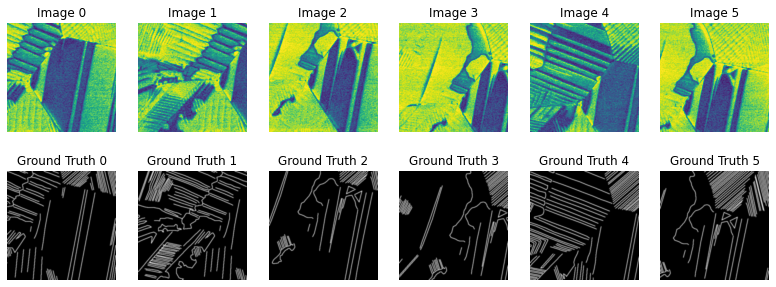

In [ ]:
# show training images
n = 5

n = n + 2
fig = plt.figure(figsize=(16, 5))
for i in range(1, n):   
    ax = fig.add_subplot(2, n, i)
    ax.imshow(x_train[i-1,0,])
    ax.axis('off')
    ax.set_title('Image ' + str(i-1) )
    ax = fig.add_subplot(2, n, i+n)
    if labs.shape[1] == 1:
        ax.imshow(y_train[i-1, 0], cmap='gray', interpolation='Gaussian')
        ax.axis('off')
    else:
        ax.imshow(y_train[i-1, 0], cmap='gray', interpolation='Gaussian')
        ax.axis('off')
    ax.set_title('Ground Truth ' + str(i-1))

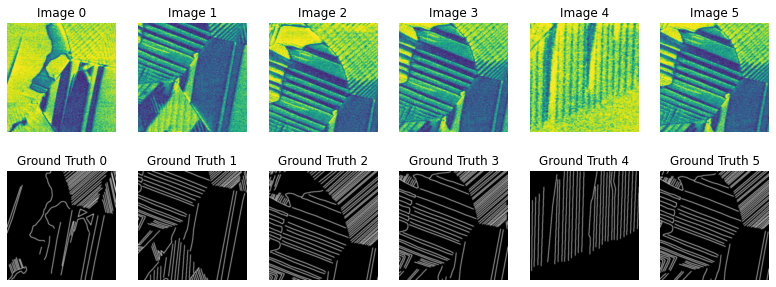

In [ ]:
# show validation images
n = 5

n = n + 2
fig = plt.figure(figsize=(16, 5))
for i in range(1, n):   
    ax = fig.add_subplot(2, n, i)
    ax.imshow(x_val[i-1,0,])
    ax.axis('off')
    ax.set_title('Image ' + str(i-1) )
    ax = fig.add_subplot(2, n, i+n)
    if labs.shape[1] == 1:
        ax.imshow(y_val[i-1, 0], cmap='gray', interpolation='Gaussian')
        ax.axis('off')
    else:
        ax.imshow(y_val[i-1, 0], cmap='gray', interpolation='Gaussian')
        ax.axis('off')
    ax.set_title('Ground Truth ' + str(i-1))

## **Define and train the model**


*  A residue network with Y-net structure was defined and trained
*  In the model, the input channels can be splited into n parts and each part was feed to equivalent conv layers, then each conv layer produces 1/n output channels and all output channels are subsequently concatenated. 


Define a model based on [holistically-nested edge detector](https://arxiv.org/pdf/1504.06375.pdf):

In [ ]:
#@title Run this cell to define a model 
class ResBlock(nn.Module):
    """
    Builds a residual block
    """
    def __init__(self, nb_filters_in=20, nb_filters_out=40, lrelu_a=0.001,
                use_batchnorm=False):
        """
        Args:
            nb_filters_in (int): number of channels in the block input
            nb_filters_out (int): number of channels in the block output
            lrelu_a=0 (float): negative slope value for leaky ReLU
        """
        super(ResBlock, self).__init__()
        self.lrelu_a = lrelu_a
        self.use_batchnorm = use_batchnorm
        self.c0 = nn.Conv2d(nb_filters_in,
                            nb_filters_out,
                            kernel_size=1,
                            stride=1,
                            padding=0, groups = 1 )                
        self.c1 = nn.Conv2d(nb_filters_out,
                           nb_filters_out,
                           kernel_size=3,
                           stride=1,
                           padding=1, groups = 2)
        self.c2 = nn.Conv2d(nb_filters_out,
                           nb_filters_out,
                           kernel_size=3,
                           stride=1,
                           padding=1, groups = 4)
        self.bn1 = nn.BatchNorm2d(nb_filters_out)
        self.bn2 = nn.BatchNorm2d(nb_filters_out)

    def forward(self, x):
        """Defines forward pass"""
        x = self.c0(x)
        residual = x
        out = self.c1(x)
        if self.use_batchnorm:
            out = self.bn1(out)
        out = F.leaky_relu(out, negative_slope=self.lrelu_a)
        out = self.c2(out)
        if self.use_batchnorm:
            out = self.bn2(out)
        out += residual
        out = F.leaky_relu(out, negative_slope=self.lrelu_a)
        return out

class ResModule(nn.Module):
    """
    Stitches multiple convolutional blocks with residual connections together
    """
    def __init__(self, input_channels, output_channels, res_depth,
                 lrelu_a=0.1, use_batchnorm=False):
        """
        Args:
            input_channels (int): number of filters in the input layer
            output_channels (int): number of channels in the output layer
            res_depth (int): number of residual blocks in a residual module
        """
        super(ResModule, self).__init__()
        res_module = []
        for i in range(res_depth):
            input_channels = output_channels if i > 0 else input_channels
            res_module.append(
                ResBlock(input_channels, output_channels,
                         lrelu_a=lrelu_a, use_batchnorm=use_batchnorm))
        self.res_module = nn.Sequential(*res_module)

    def forward(self, x):
        """Defines a forward pass"""
        x = self.res_module(x)
        return x

class hednet(nn.Module):
    def __init__(self):
        super(hednet, self).__init__()
        self.net1 = ResModule(1, 100, 4, use_batchnorm=True)
        self.net2 = nn.Sequential(
			nn.MaxPool2d(2, 2),
			ResModule(100, 200, 5, use_batchnorm=True)
		)
        self.net3 = nn.Sequential(
			nn.MaxPool2d(2, 2),
			ResModule(200, 400, 6, use_batchnorm=True)
		)
        self.net1score = nn.Sequential(
            nn.Conv2d(100, 1, 1, 1, 0),
            nn.BatchNorm2d(1)
        )
        self.net2score = nn.Sequential(nn.Conv2d(
            200, 1, 1, 1, 0),
            nn.BatchNorm2d(1)
        )
        self.net3score = nn.Sequential(nn.Conv2d(
            400, 1, 1, 1, 0),
            nn.BatchNorm2d(1)
        )
        self.out = torch.nn.Conv2d(3, 1, 1, 1, 0)
    
    def forward(self, x):
        h, w = x.shape[2:4]
        net1out = self.net1(x)
        net2out = self.net2(net1out)
        net3out = self.net3(net2out)

        score1 = self.net1score(net1out)
        score2 = self.net2score(net2out)
        score3 = self.net3score(net3out)

        score2 = F.interpolate(score2, size=(h, w), mode='bilinear')
        score3 = F.interpolate(score3, size=(h, w), mode='bilinear')

        return self.out(torch.cat([score1, score2, score3], 1))

Train a single model

In [ ]:
t = aoi.atomnet.trainer(x_train, y_train, x_val, y_val, 
                        model=hednet(), training_cycles=3000, full_epoch=False, IoU=True,
                        batch_size=4, swa=True, loss='focal', contrast=True, blur=True)      #trained model can be saved by inserting 'filename='...' and add save direction

trained_model = t.run()

# **Test the model using validation data**


*   Make predictions on the validation data sets 
*   A comparison of predictions with ground truth shows that predicted wall maps are well consistent with ground truth



Make precition on validation images and compare with ground truth

In [ ]:
p = aoi.atomnet.predictor(trained_model, use_gpu=True)
prediction, _ = p.run(x_val)

/usr/local/lib/python3.7/dist-packages/atomai/atomnet/infer.py:163: UserWarning: The default output of predictor.decode() and predictor.run() is now ```nn_output, coords``` instead of ```nn_input, (nn_output, coords)```
  warnings.warn(warn_msg, UserWarning)


Batch 560/560
560 images were decoded in approximately 56.071 seconds


Text(0.5, 1.0, 'Ground Truth')

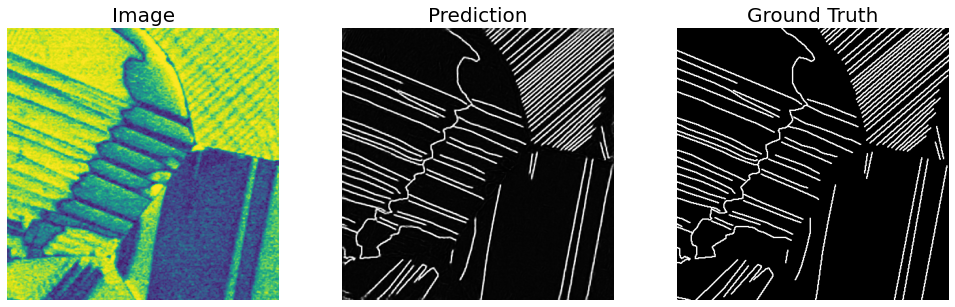

In [ ]:
k = 9
_,(ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(17, 5))
ax0.imshow(x_val[k, 0])
ax0.axis ('off')
ax0.set_title('Image', fontsize = 20)
ax1.imshow(prediction[k,...,0], cmap = 'gray')
ax1.axis('off')
ax1.set_title('Prediction', fontsize = 20)
ax2.imshow(lab_val[k, 0], cmap = 'gray')
ax2.axis('off')
ax2.set_title('Ground Truth', fontsize = 20)

# **Predict target data set**


*   Make prediction on a target dataset
*   Although predicted maps well inditifed domain walls, there are some discontinuous walls. To resolve the discontinuities, the raw images were first denoised and then feed to the model.



Make prediction on a target dataset

In [ ]:
tar_img = np.load(r'/content/test_imgs2.npy')

pred_tar_img = aoi.atomnet.predictor(trained_model, use_gpu=True).run(tar_img)[0][:, :, :, 0]

/usr/local/lib/python3.7/dist-packages/atomai/atomnet/infer.py:163: UserWarning: The default output of predictor.decode() and predictor.run() is now ```nn_output, coords``` instead of ```nn_input, (nn_output, coords)```
  warnings.warn(warn_msg, UserWarning)


Batch 39/39
39 images were decoded in approximately 10.0652 seconds


Show raw image and prediction

Text(0.5, 1.0, 'prediction 16')

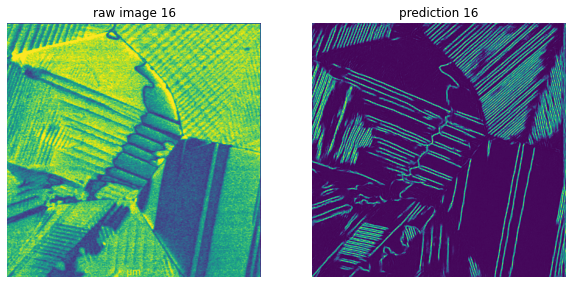

In [ ]:
k = 16
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow(tar_img[k, ...])
ax1.axis('off')
ax1.set_title('raw image '+str(k))
ax2.imshow(pred_tar_img[k, ...])
ax2.axis('off')
ax2.set_title('prediction '+str(k))

Denoise raw images by Gaussian filter to improve prediction quality

In [ ]:
sigma=1
tar_img_gau = gaussian_filter(tar_img, sigma = sigma)

pred_tar_img_gau = aoi.atomnet.predictor(trained_model, use_gpu=True).run(tar_img_gau)[0][:, :, :, 0]

/usr/local/lib/python3.7/dist-packages/atomai/atomnet/infer.py:163: UserWarning: The default output of predictor.decode() and predictor.run() is now ```nn_output, coords``` instead of ```nn_input, (nn_output, coords)```
  warnings.warn(warn_msg, UserWarning)


Batch 39/39
39 images were decoded in approximately 10.0574 seconds


Show rawimage, prediction, denoised image, and prediction (on denoise image)

Text(0.5, 1.0, 'prediction on denoised image')

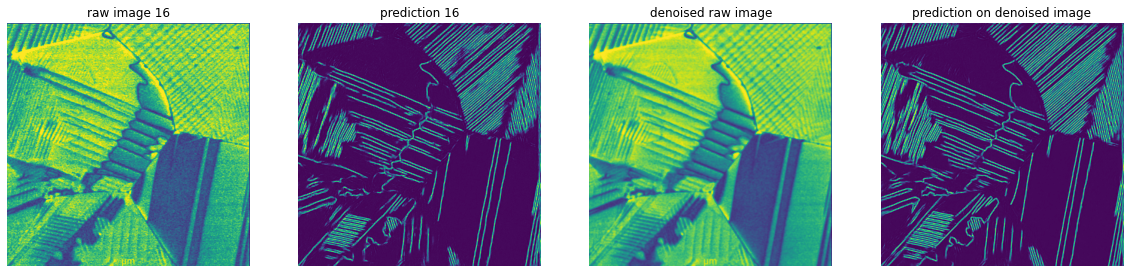

In [ ]:
k = 16
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
ax1.imshow(tar_img[k, ...])
ax1.axis('off')
ax1.set_title('raw image ')
ax2.imshow(pred_tar_img[k, ...])
ax2.axis('off')
ax2.set_title('prediction ')
ax3.imshow(tar_img_gau[k, ...])
ax3.axis('off')
ax3.set_title('denoised raw image')
ax4.imshow(pred_tar_img_gau[k, ...])
ax4.axis('off')
ax4.set_title('prediction on denoised image')